# 2. Data Exploration
<hr>

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import argparse # command line parsing module
import pickle # for serializing python objects to byte stream

In [2]:
from datetime import datetime
import time
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
pd.options.mode.chained_assignment  = None # for running loops quicker without warnings

In [3]:
name = 'small_log'

#define parser
parser = {
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'input_dir': '../input/{}/'.format(name),  
    'train_pct': 0.6,
    'anomaly_pct': 0.1,
    'val_pct': 0.2,
    'scaler': 'standardization',
}

args = argparse.Namespace(**parser)

In [4]:
if not os.path.isdir('../input/'):
    os.makedirs('../input/')
    
if not os.path.isdir(args.input_dir):
    os.makedirs(args.input_dir)

In [5]:
sys.path.insert(0, './../utils/')
from utils import *

In [6]:
# read the data saved during preprocessing

preprocessed_data_name = os.path.join(args.input_dir,'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    activity_label_test = pickle.load(f)
    time_label_test = pickle.load(f)
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    mean_value = pickle.load(f)
    std_value = pickle.load(f)
    cols = pickle.load(f)
    statistics_storage = pickle.load(f)
    true_time = pickle.load(f)
    true_act = pickle.load(f)
    full_true_time = pickle.load(f)
    full_true_act = pickle.load(f)

## Loading the data

In [7]:
normal_df_name = os.path.join(args.input_dir, 'normal_df_{}.csv'.format(args.anomaly_pct))
normal_df = pd.read_csv(normal_df_name)

normal_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration
0,1,Activity A,1970-01-01 09:00:00,0.0,0.0
1,1,Activity B,1970-01-01 10:00:00,3600.0,3600.0
2,1,Activity C,1970-01-01 11:00:00,3600.0,7200.0
3,1,Activity D,1970-01-01 12:00:00,3600.0,10800.0
4,1,Activity E,1970-01-01 13:00:00,3600.0,14400.0


In [8]:
anomalous_df_name = os.path.join(args.input_dir, 'anomalous_df_{}.csv'.format(args.anomaly_pct))
anomalous_df = pd.read_csv(anomalous_df_name)

anomalous_df.head()

,CaseID,AnomalousActivity,AnomalousCompleteTimestamp,AnomalousDuration,AnomalousCumDuration,ActivityLabel,TimeLabel
0,1,Activity A,1970-01-01 09:00:00.000000,0.000000,0.000000,0,0
1,1,Activity B,1970-01-01 10:35:58.004936,5758.004936,5758.004936,0,1
2,1,Activity C,1970-01-01 11:00:00.000000,3600.000000,7200.000000,0,0
3,1,Activity D,1970-01-01 12:00:00.000000,3600.000000,10800.000000,0,0
4,1,Activity E,1970-01-01 13:58:58.395297,7138.395297,17938.395297,0,1


## Histogram

In [21]:
# Function for showing histogram of duration for particular activity indf
def histogram_plot(df, activity):
    selected_df = df[df['Activity']==activity]['Duration']
    selected_df.hist()
    plt.axvline(selected_df.mean(), color='m', linestyle='dashed', linewidth=2)
    plt.axvline(selected_df.mean()+selected_df.std(), color='r', linestyle='dashed', linewidth=2)
    plt.title('Histogram of '+ act)
    plt.savefig(args.input_dir + 'histogram_'+act)
    plt.show()
    plt.close()

In [22]:
act_list = normal_df['Activity'].unique()
print('Activities: {}'.format(act_list))

Activities: ['Activity A' 'Activity B' 'Activity C' 'Activity D' 'Activity E'
 'Activity K' 'Activity G' 'Activity M' 'Activity L' 'Activity I'
 'Activity J' 'Activity N' 'Activity H' 'Activity F']


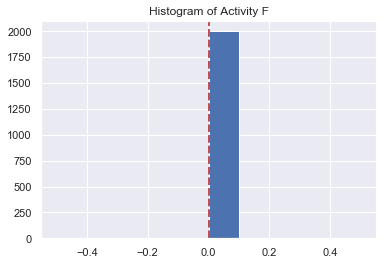

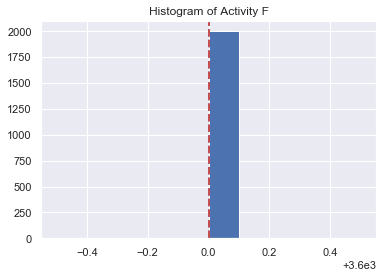

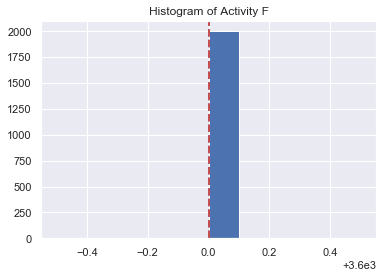

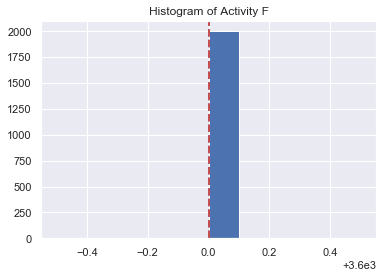

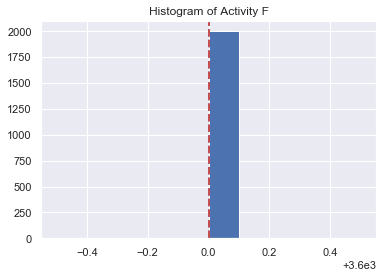

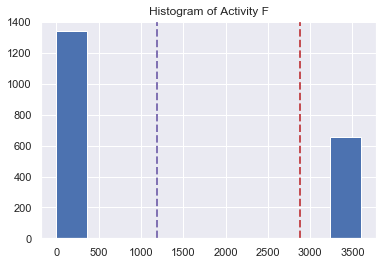

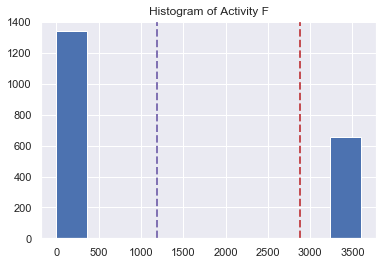

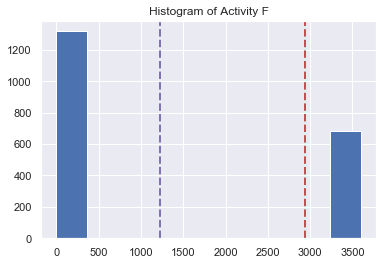

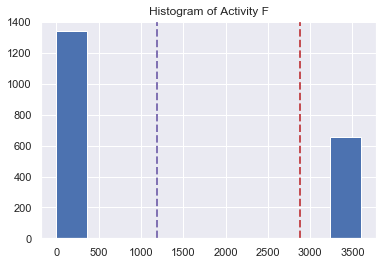

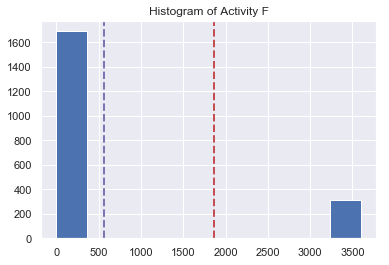

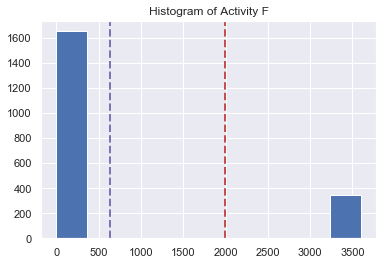

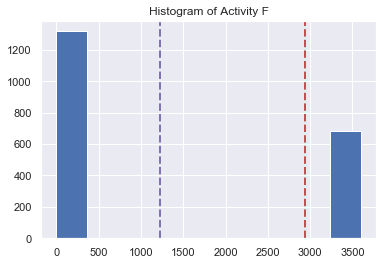

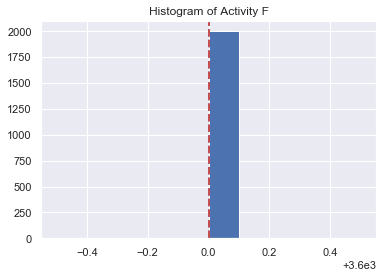

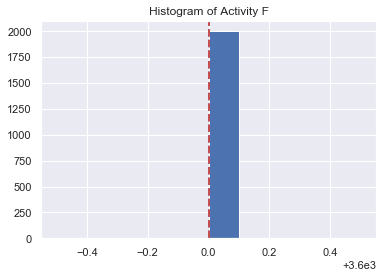

In [23]:
for activity in act_list:
    histogram_plot(normal_df, activity)

## Duration of activities

- Full set

In [1]:
normal_df['Duration'].describe()

NameError: name 'normal_df' is not defined

In [ ]:
print('Activity average durations\n')
normal_df.groupby('Activity')['Duration'].sum() / normal_df.groupby('Activity')['Duration'].count()

In [24]:
temp = pd.DataFrame({'Activity': normal_df['Activity'].copy(),
                     'AnomalousDuration': anomalous_df['AnomalousDuration'].copy(),
                     'TimeLabel': anomalous_df['TimeLabel'].copy()})

In [25]:
temp.head()

,Activity,AnomalousDuration,TimeLabel
0,Activity A,0.000000,0
1,Activity B,5758.004936,1
2,Activity C,3600.000000,0
3,Activity D,3600.000000,0
4,Activity E,7138.395297,1


In [26]:
groupByActivity = temp.groupby(['Activity'])
groupByActivity.head()

,Activity,AnomalousDuration,TimeLabel
0,Activity A,0.000000,0
1,Activity B,5758.004936,1
2,Activity C,3600.000000,0
3,Activity D,3600.000000,0
4,Activity E,7138.395297,1
...,...,...,...
65,Activity L,0.000000,0
66,Activity I,0.000000,0
67,Activity J,0.000000,0
68,Activity H,3600.000000,0


In [29]:
import math

In [46]:
# function to plot the duration for anomalous and normal data
def plotDuration(activity, df, save=True):
    fig, ax = plt.subplots(figsize=(10, 5))
    anomaly = df[df['TimeLabel']==1]
    normal = df[df['TimeLabel']==0]
    
    ax.plot(anomaly.index, anomaly.AnomalousDuration, marker='o', ms=3.5, linestyle='', color='green', label=str(len(anomaly)))
    ax.plot(normal.index, normal.AnomalousDuration, marker='o', ms=3.5, linestyle='', color='cornflowerblue', label=str(len(normal)))
    
    plt.xlabel('Data point index')
    plt.ylabel('Duration')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save == True:
        plt.savefig(args.input_dir + 'duration_'+act, bbox_inches='tight')
    plt.show()
    plt.close()
    

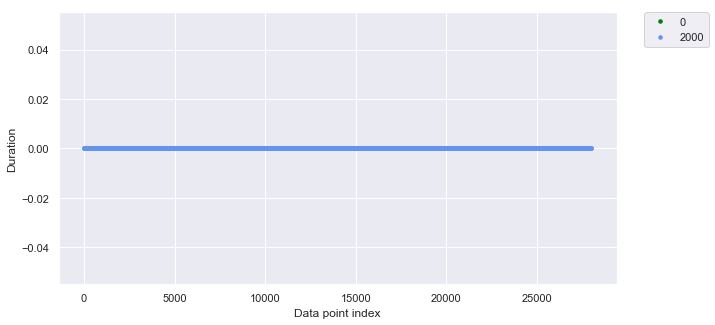

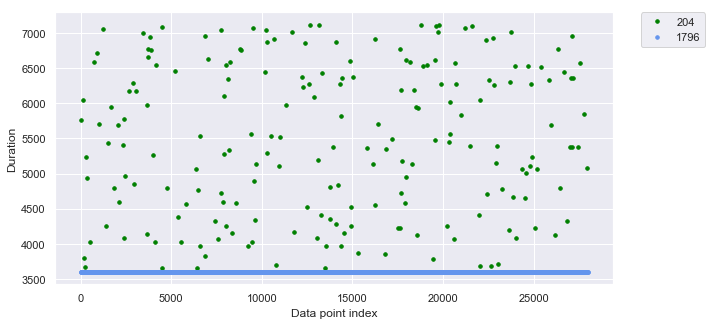

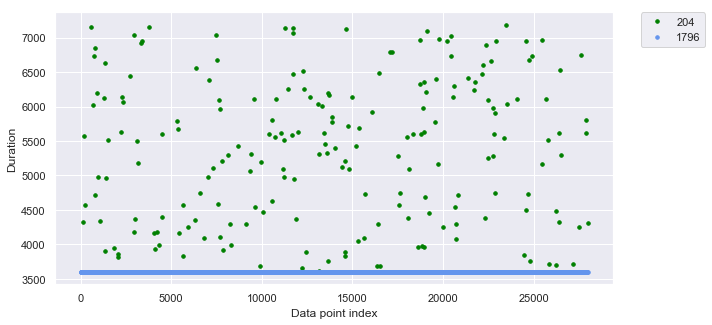

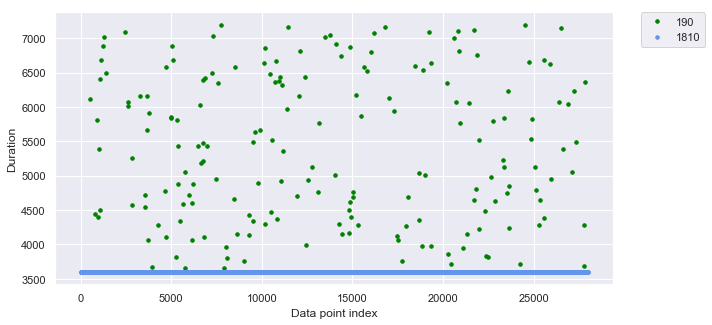

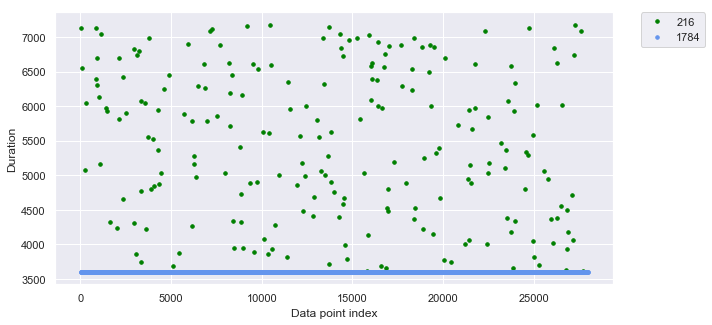

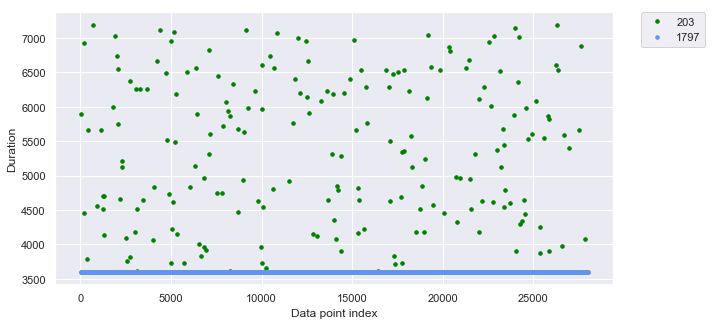

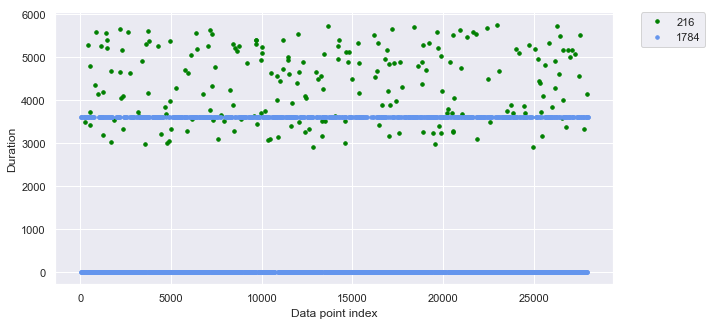

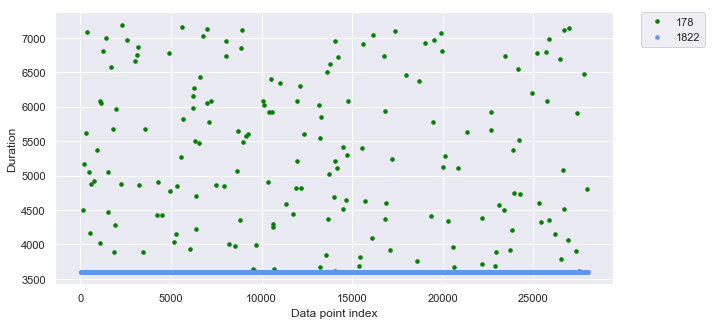

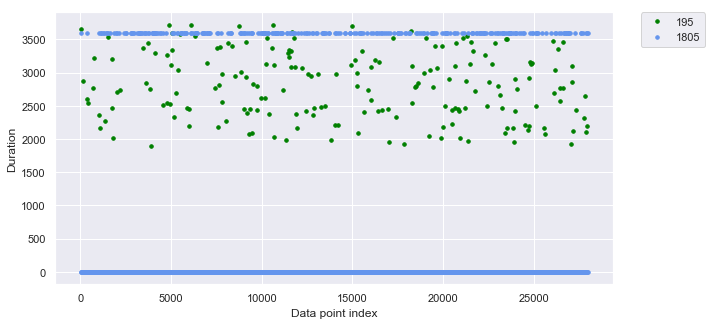

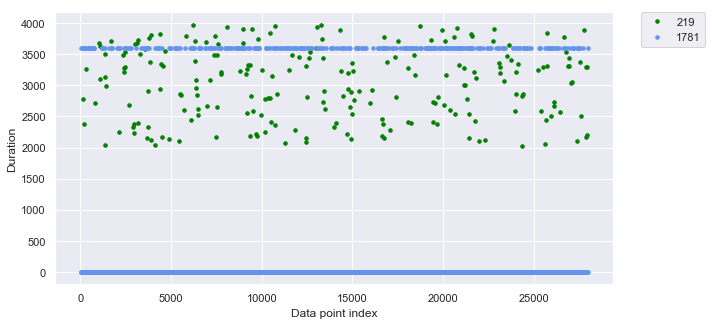

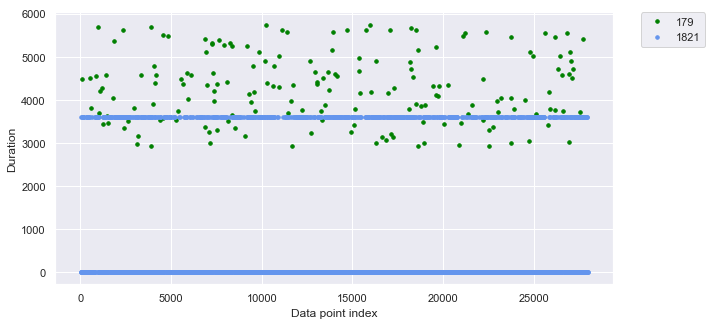

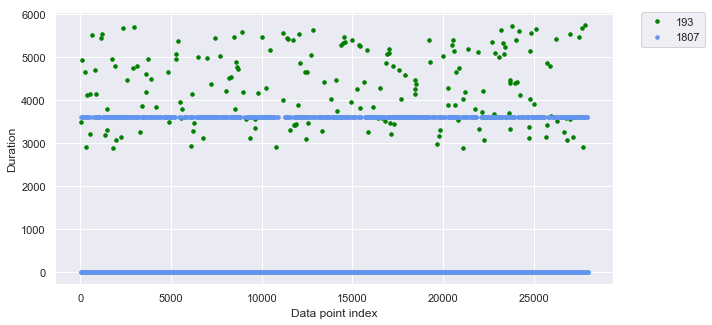

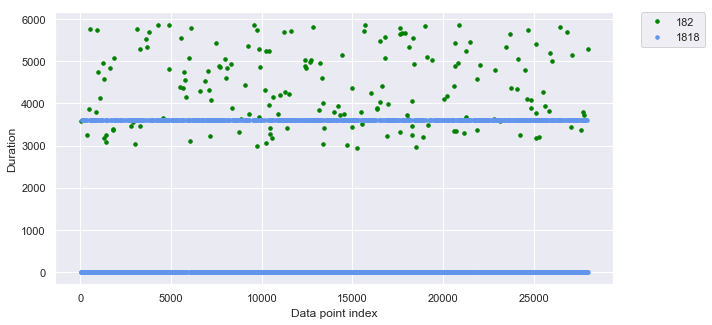

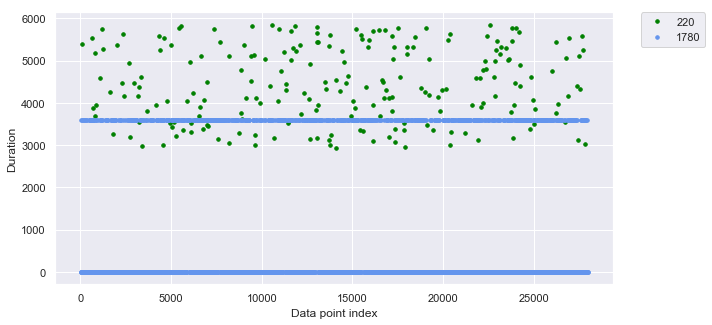

In [47]:
for act, group in groupByActivity:
    plotDuration(act, group, True)

- Test Set

In [48]:
temp_test = temp[-test_row_num:]

,Activity,AnomalousDuration,TimeLabel
22400,Activity A,0.00000,0
22401,Activity B,3600.00000,0
22402,Activity C,3600.00000,0
22403,Activity D,3600.00000,0
22404,Activity E,4002.43999,1


In [49]:
groupByActivity = temp_test.groupby(['Activity'])
groupByActivity.head()

,Activity,AnomalousDuration,TimeLabel
22400,Activity A,0.00000,0
22401,Activity B,3600.00000,0
22402,Activity C,3600.00000,0
22403,Activity D,3600.00000,0
22404,Activity E,4002.43999,1
...,...,...,...
22465,Activity I,0.00000,0
22466,Activity J,0.00000,0
22467,Activity L,0.00000,0
22468,Activity H,3600.00000,0


C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


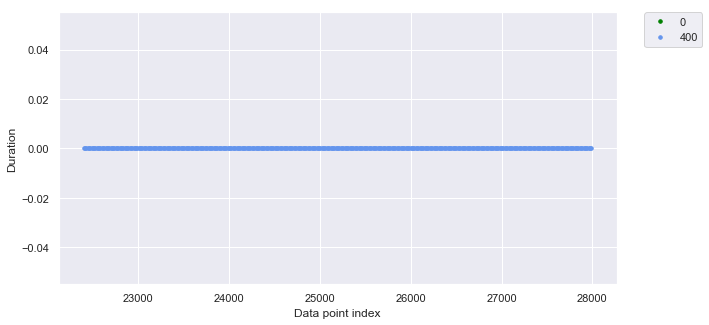

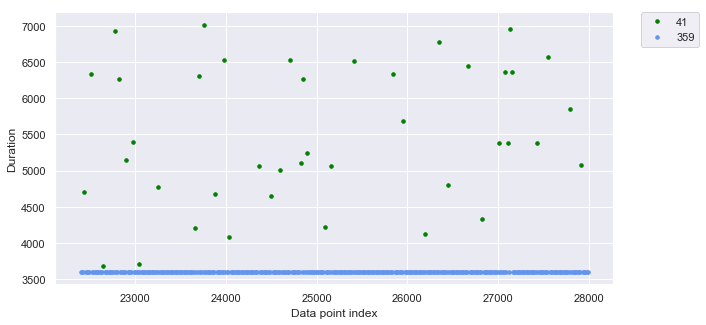

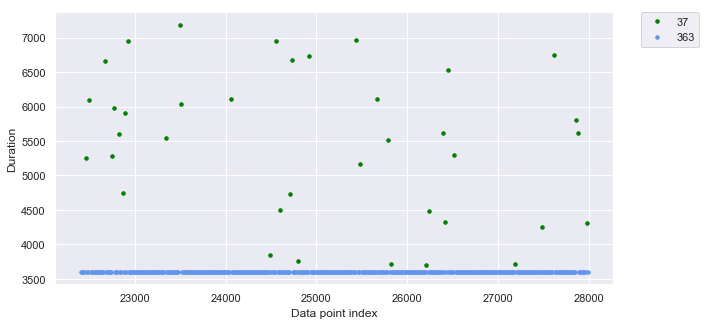

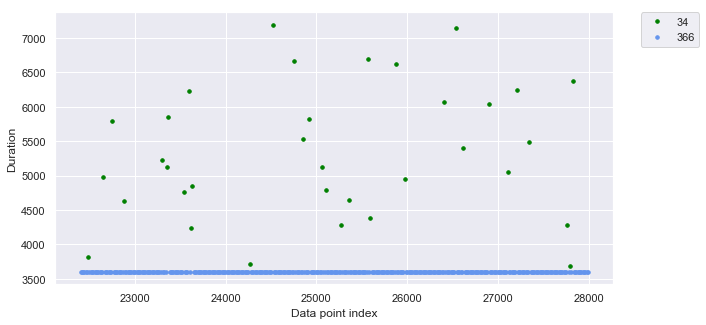

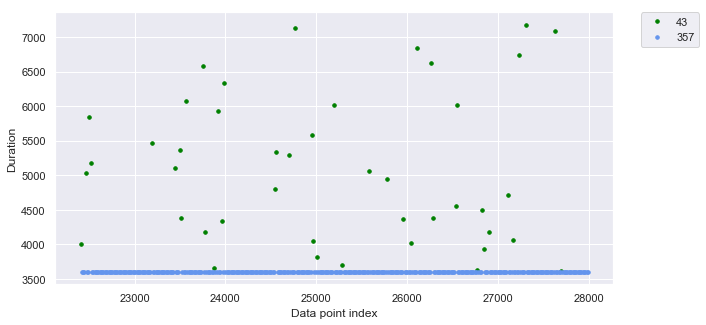

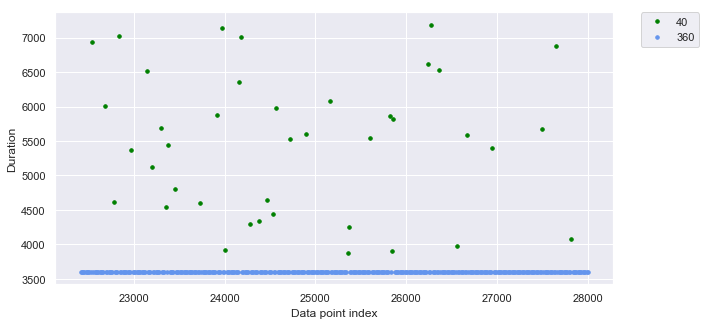

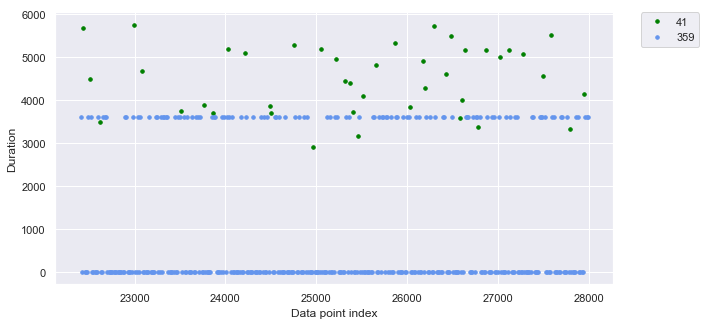

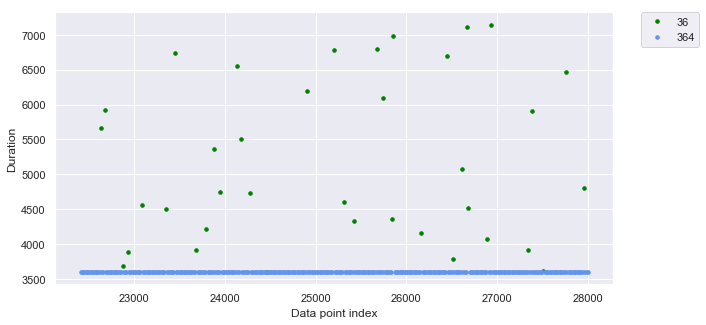

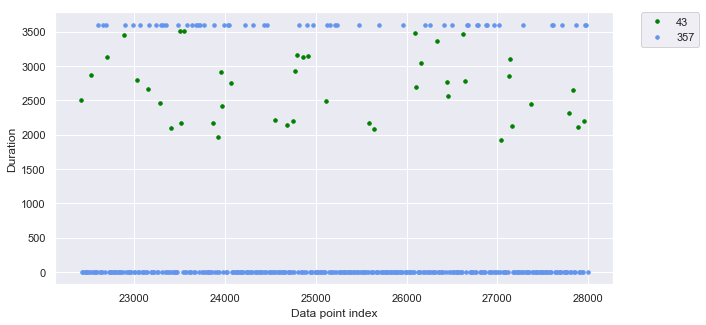

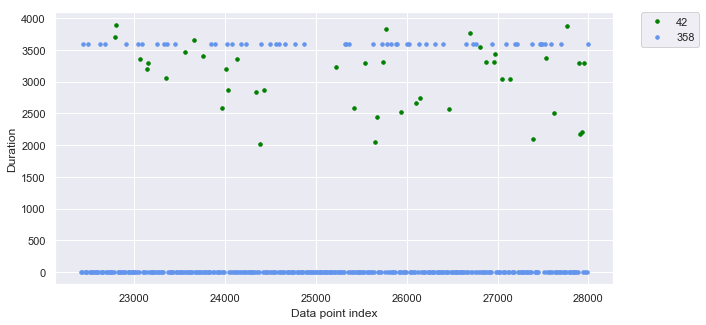

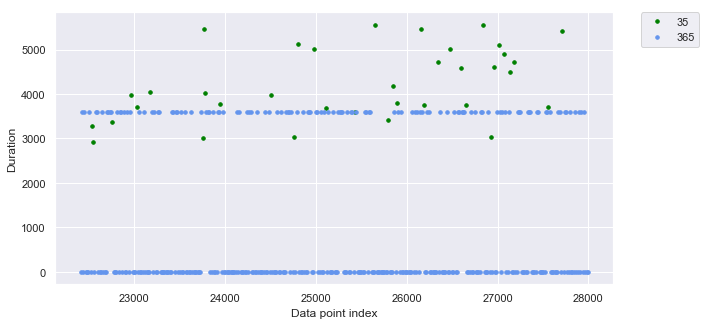

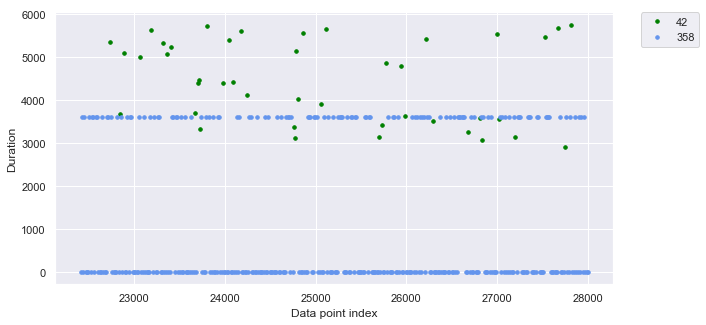

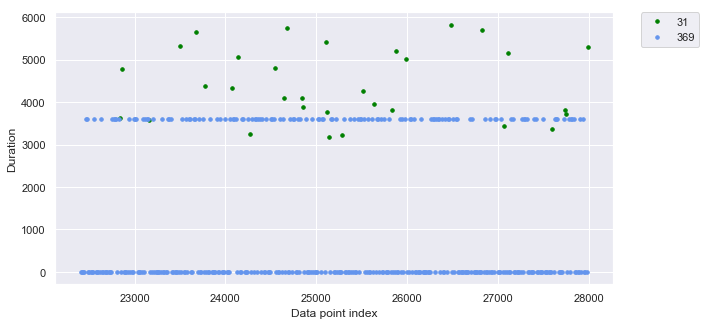

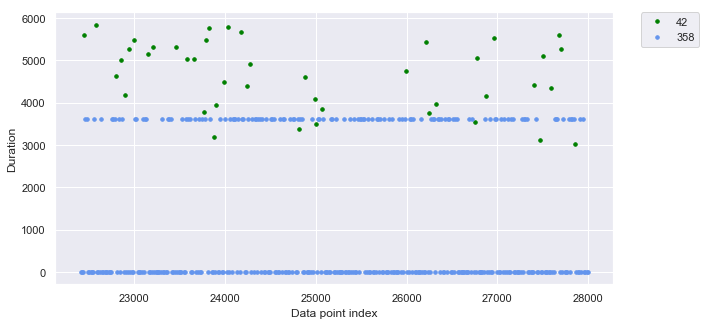

In [50]:
for act, group in groupByActivity:
    plotDuration(act, group, False)